In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
from algos.nmcsTimed import *
from algos.nrpasTimed import *
from utils import *
from base import *

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [4]:
filename = "../data/c_memorable_moments.txt"

In [5]:
def get_score(ss_idx):
    ss = Slideshow()
    [ss.add_right(SLIDES[s]) for s in ss_idx]
    return sum(ss.scores)

@timeit
def mean_scores(n, sol, stabilized=False, monitor_time=False, delay=1000):
    scores = []
    for i in range(30):
        if stabilized:
            if monitor_time:
                ss = sol.run(n, verbose=0, stabilized=True, monitor_time=True, delay=delay)
            else:
                ss = sol.run(n, verbose=0, stabilized=True)
        else:
            if monitor_time:
                ss = sol.run(n, verbose=0, monitor_time=True, delay=delay)
            else:
                ss = sol.run(n, verbose=0)
        score = np.sum(ss.scores)
        scores.append(score)
    return np.mean(scores), scores

## NRPA
The first improvement over NMCS that we implemented is NRPA. We will see how it compares with NMCS for different compute times 

In [6]:
initial_time = 0.06
search_times = [initial_time]
for k in range(5):
    search_times.append(initial_time*2)
    initial_time = initial_time*2

In [7]:
NMCS_score = []
NRPA_score = []
for compute_time in search_times:
    # Run NMCS and get the score after compute_time
    sol = NestedMCSolutionTimed(filename, max_slides=50)
    a, b = mean_scores(2, sol, monitor_time=True, delay=compute_time)
    NMCS_score.append(a)
    
    # Run NRPA and get the score after compute_time
    sol = NRPASolutionTimed(filename, max_slides=50)
    sa, sb = mean_scores(2, sol, monitor_time=True, delay=compute_time)
    NRPA_score.append(sa)

df = pd.DataFrame(np.transpose(np.array([search_times, NMCS_score, NRPA_score])), columns=['searchTime','NMCS', 'NRPA'])
display(df)

1000 photos caught.
func:'form_slides' took: 0.0034 sec
Num slides : 750
func:'mean_scores' took: 3.6249 sec
1000 photos caught.
func:'form_slides' took: 0.0000 sec
Num slides : 750
func:'mean_scores' took: 2.3029 sec
1000 photos caught.
func:'form_slides' took: 0.0081 sec
Num slides : 750
func:'mean_scores' took: 5.6417 sec
1000 photos caught.
func:'form_slides' took: 0.0000 sec
Num slides : 750
func:'mean_scores' took: 4.0720 sec
1000 photos caught.
func:'form_slides' took: 0.0000 sec
Num slides : 750
func:'mean_scores' took: 9.2227 sec
1000 photos caught.
func:'form_slides' took: 0.0000 sec
Num slides : 750
func:'mean_scores' took: 7.7023 sec
1000 photos caught.
func:'form_slides' took: 0.0105 sec
Num slides : 750
func:'mean_scores' took: 16.1950 sec
1000 photos caught.
func:'form_slides' took: 0.0082 sec
Num slides : 750
func:'mean_scores' took: 14.8869 sec
1000 photos caught.
func:'form_slides' took: 0.0083 sec
Num slides : 750
func:'mean_scores' took: 29.6849 sec
1000 photos caug

,searchTime,NMCS,NRPA
0,0.06,0.000000,14.400000
1,0.12,0.333333,15.300000
2,0.24,1.466667,15.800000
3,0.48,3.400000,17.333333
4,0.96,8.300000,19.033333
5,1.92,15.566667,19.300000


We can see that using our best implementation of NRPA provides better results than our best implementation of NMCS for each compute time.

## Stabilized NRPA

Stabilized NRPA is a simple modification of the NRPA algorithm. It consists in periodically playing P playouts at the lowest level before performing the adaptation.

### Picking a good P value 
We set N=50 and level=2 in order to evaluate an appropriate P value. We iterate through 1 to 10.

In [8]:
from algos.nrpas import *

p_score = []
for p in range(1,10):
    sol = NRPASolution(filename, max_slides=50, N=50, P=p)
    a, b = mean_scores(2, sol, True)
    p_score.append(a)

1000 photos caught.
func:'form_slides' took: 0.0022 sec
Num slides : 750
func:'mean_scores' took: 3.0014 sec
1000 photos caught.
func:'form_slides' took: 0.0066 sec
Num slides : 750
func:'mean_scores' took: 5.4010 sec
1000 photos caught.
func:'form_slides' took: 0.0021 sec
Num slides : 750
func:'mean_scores' took: 7.2629 sec
1000 photos caught.
func:'form_slides' took: 0.0159 sec
Num slides : 750
func:'mean_scores' took: 9.0680 sec
1000 photos caught.
func:'form_slides' took: 0.1002 sec
Num slides : 750
func:'mean_scores' took: 12.0212 sec
1000 photos caught.
func:'form_slides' took: 0.0000 sec
Num slides : 750
func:'mean_scores' took: 14.4006 sec
1000 photos caught.
func:'form_slides' took: 0.0157 sec
Num slides : 750
func:'mean_scores' took: 15.7505 sec
1000 photos caught.
func:'form_slides' took: 0.0156 sec
Num slides : 750
func:'mean_scores' took: 16.9364 sec
1000 photos caught.
func:'form_slides' took: 0.0000 sec
Num slides : 750
func:'mean_scores' took: 19.5639 sec


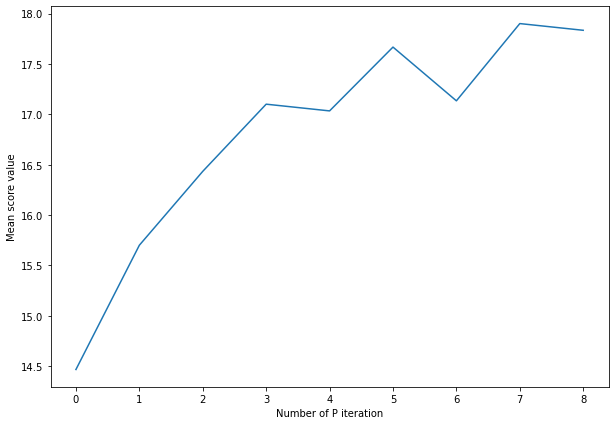

In [9]:
plt.figure(figsize=(10,7))
plt.plot(p_score)
plt.ylabel('Mean score value')
plt.xlabel('Number of P iteration')
plt.show()

Evaluation improves the performance for a growing P value. Thus, P=10 yields the best performance. 

### NRPA vs SNRPA(10)
Let's see with different compute time which algorithm yield the best performance

In [10]:
SNRPA_score = []
NRPA_score = []
for compute_time in search_times:
    # Run NRPA and get the score after compute_time
    sol = NRPASolutionTimed(filename, max_slides=50)
    sa, sb = mean_scores(2, sol, monitor_time=True, delay=compute_time)
    NRPA_score.append(sa)
    
    # Run SNRPA with P=10 and get the score after compute_time
    sol = NRPASolutionTimed(filename, max_slides=50)
    sa, sb = mean_scores(2, sol, True, monitor_time=True, delay=compute_time)
    SNRPA_score.append(sa)
    
df = pd.DataFrame(np.transpose(np.array([search_times,NRPA_score,SNRPA_score])), columns=['computeTime','NRPA_score', 'SNRPA_score'])
display(df)

1000 photos caught.
func:'form_slides' took: 0.0044 sec
Num slides : 750
func:'mean_scores' took: 2.2208 sec
1000 photos caught.
func:'form_slides' took: 0.0000 sec
Num slides : 750
func:'mean_scores' took: 2.2475 sec
1000 photos caught.
func:'form_slides' took: 0.0000 sec
Num slides : 750
func:'mean_scores' took: 4.2922 sec
1000 photos caught.
func:'form_slides' took: 0.0000 sec
Num slides : 750
func:'mean_scores' took: 4.2467 sec
1000 photos caught.
func:'form_slides' took: 0.0000 sec
Num slides : 750
func:'mean_scores' took: 7.8044 sec
1000 photos caught.
func:'form_slides' took: 0.0000 sec
Num slides : 750
func:'mean_scores' took: 7.6859 sec
1000 photos caught.
func:'form_slides' took: 0.0156 sec
Num slides : 750
func:'mean_scores' took: 14.8594 sec
1000 photos caught.
func:'form_slides' took: 0.0033 sec
Num slides : 750
func:'mean_scores' took: 14.9964 sec
1000 photos caught.
func:'form_slides' took: 0.0000 sec
Num slides : 750
func:'mean_scores' took: 29.3267 sec
1000 photos caug

,computeTime,NRPA_score,SNRPA_score
0,0.06,14.533333,13.900000
1,0.12,15.633333,15.333333
2,0.24,16.500000,15.733333
3,0.48,16.900000,16.966667
4,0.96,18.366667,18.766667
5,1.92,19.000000,19.100000
